<a href="https://colab.research.google.com/github/AlexanderLontke/ssl-remote-sensing/blob/main/notebooks/BiGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN Implementation Remote Sensing

## Import necessary packages

In [ ]:
!pip install rasterio
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import standard python libraries
import os
import datetime as time
from datetime import datetime
import numpy as np
import pickle as pkl
import glob
from pathlib import Path
from math import floor
import random
from itertools import chain

# import data reader, logging and transforms
from torchvision import transforms
from torchvision import datasets
import rasterio as rio
from rasterio.plot import reshape_as_image
import wandb

# import the PyTorch deep learning library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
from torch.autograd import Variable

# import matplotlib and enabling notebook inline plotting:
import matplotlib.pyplot as plt
%matplotlib inline

Mount Google Drive Directories for data access

In [ ]:
# import the Google Colab GDrive connector
from google.colab import drive

# mount GDrive inside the Colab notebook
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# create Colab Notebooks directory
notebook_directory = Path('/content/drive/MyDrive/Projects/DeepLearning')
if not os.path.exists(notebook_directory): os.makedirs(notebook_directory)

 # create data sub-directory inside the Colab Notebooks directory
data_directory = Path('/content/drive/MyDrive/Projects/DeepLearning/data')
if not os.path.exists(data_directory): os.makedirs(data_directory)

 # create models sub-directory inside the Colab Notebooks directory
models_directory = Path('/content/drive/MyDrive/Projects/DeepLearning/models')
if not os.path.exists(models_directory): os.makedirs(models_directory)

## Helper Functions

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with cuda computation enabled


In [ ]:
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
if device == "cuda":
  torch.cuda.manual_seed(SEED)

## Data

Define the directory on your drive to reproduce results. Downloaded data from https://madm.dfki.de/files/sentinel/EuroSATallBands.zip should be within the data folder created in previous steps. 

In [ ]:
IMAGE_SIZE = 64
transformer_train = transforms.Compose([
                               transforms.ToTensor(),
                               #transforms.Resize(IMAGE_SIZE),
                               #transforms.CenterCrop(IMAGE_SIZE),
                               #transforms.Normalize([87.81586935763889, 96.97416420717593, 103.98142336697049], [51.67849701591506, 34.908630837585186, 29.465280593587384]),
                           ])

transformer_test = transforms.Compose([
                               transforms.ToTensor(),
                               #transforms.Resize(IMAGE_SIZE),
                               #transforms.CenterCrop(IMAGE_SIZE),
                               #transforms.Normalize([87.81586935763889, 96.97416420717593, 103.98142336697049], [51.67849701591506, 34.908630837585186, 29.465280593587384]),
                           ])

In [ ]:
torchvision_eurosat_dir = data_directory.joinpath("eurosat")
data = datasets.EuroSAT(root = torchvision_eurosat_dir, transform = transformer_train, download = True)

In [ ]:
data[0]

(tensor([[[0.5843, 0.5765, 0.5725,  ..., 0.4000, 0.4078, 0.4039],
          [0.5843, 0.5843, 0.5843,  ..., 0.4000, 0.4078, 0.4039],
          [0.5608, 0.5647, 0.5765,  ..., 0.4000, 0.4000, 0.4039],
          ...,
          [0.5529, 0.5529, 0.5373,  ..., 0.4039, 0.3922, 0.3961],
          [0.5098, 0.5176, 0.5059,  ..., 0.4118, 0.4118, 0.4196],
          [0.4784, 0.4784, 0.4706,  ..., 0.4157, 0.4157, 0.4196]],
 
         [[0.4745, 0.4745, 0.4706,  ..., 0.3529, 0.3608, 0.3569],
          [0.4745, 0.4745, 0.4667,  ..., 0.3529, 0.3608, 0.3569],
          [0.4588, 0.4510, 0.4549,  ..., 0.3608, 0.3529, 0.3569],
          ...,
          [0.4588, 0.4588, 0.4588,  ..., 0.3647, 0.3529, 0.3529],
          [0.4353, 0.4392, 0.4314,  ..., 0.3686, 0.3647, 0.3725],
          [0.4157, 0.4118, 0.4039,  ..., 0.3725, 0.3725, 0.3725]],
 
         [[0.4706, 0.4706, 0.4667,  ..., 0.3922, 0.4000, 0.3961],
          [0.4706, 0.4706, 0.4667,  ..., 0.3922, 0.4000, 0.3961],
          [0.4549, 0.4588, 0.4745,  ...,

In [ ]:
classes = {
    0: "AnnualCrop",
    1: "Forest",
    2: "HerbaceousVegetation",
    3: "Highway",
    4: "Industrial",
    5: "Pasture",
    6: "PermanentCrop",
    7: "Residential",
    8: "River",
    9: "SeaLake"
}

In [ ]:
class_to_idx = {value:key for key,value in classes.items()}

In [ ]:
print(class_to_idx)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


Create a user-defined data loader for the EuroSAT data to adjust specifically for a GAN model. This process includes transformations if wanted. 

## Setup BiGAN 
The GAN architecture is composed of the generative model $G$ and the discriminative model $D$.

The discriminator $D$ is a binary classifier trying to determine whether the input sample $X$ is real or fake. Real pictures come from the EuroSAT dataset whereas fake inputs are generated by generator $G$. Thus, $D$ outputs a scalar which is then transformed to a probability measure using the sigmoid function. 

- 1 - Sample is part of the real dataset
- 0 - Sample is a fake generated by $G$

In the BiGAN approach we not only model a generator and a discriminator, but the goal is to further extract the implicit distribution $p_z (z)$ from the generator. This is done via introducing an additional encoder network. The Encoder $E$ maps data $x$ to the latent distribution $z$. Further, the discriminator $D$ discriminates not only in data space ($x$ vs. $G(z)$), but jointly in data and latent space (tuples ($x$, $E(x)$) vs. ($G(z)$, $z$)). The latent component is either an encoder output $E(x)$ or a generator input $z$. Thus, the basic training idea remains the same as for the generator, but the training happens in the opposite direction for the encoder. 

Conclusively, we try to model a relation $E = G^{-1}$. 

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

### Discriminator
Due to the binary classification case of the discriminator we will use the BCE with logits loss because cross entropy not only punishes incorrect but confident predictions but also correct but less confident predictions. Including the logits there is no need to apply the sigmoid activation function in the network. 

### Generator
As the generator is not a discriminative model its aim is to generate data. 
Thus, we draw the latent variable $z \in \mathbb{R}^d$ from a random distribution such as a Gaussian or a uniform distribution. 
Accordingly, $G$ produces the following output: $X' = G(z)$. 
As we want to fool $D$ to fail in distinguishing fake and real remote sensing data we aspire $D(G(z)) ≈ 1$. Hence, the goal is to maximize cross-entropy loss in case $y=0$ (fake data). 

## Encoder


### MinMax-Game
We thus define the following value function $V$ by combining both the targets of $G$ and $D$:

$$min_{G}max_{D} V(D, G) = \mathbb{E}_{x∼Data} [logD(x)] + \mathbb{E}_{z∼Noise} [log(1-D(G(z)))]$$


For further training tips of GANs look at: [GAN hacks](https://https://github.com/soumith/ganhacks)

## Training

In [ ]:
class Encoder_CNN(nn.Module):
  def __init__(self, z_dim, h_dim, X_dim):
    super(Encoder_CNN, self).__init__()

    self.input_height = 64
    self.input_width = 64
    self.input_dim = 3
    self.output_dim = z_dim

    self.slope = 0.2
    self.dropout = 0.1
    self.num_channels = 3

    self.inference = nn.Sequential(
        # input dim: num_channels x 64 x 64
        nn.Conv2d(in_channels=self.num_channels, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(self.slope, inplace=True),
        # state dim: 32 x 64 x 64
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=0, bias=True),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(self.slope, inplace=True),
        # state dim: 64 x 31 x 31
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=1, padding=0, bias=True),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(self.slope, inplace=True),
        # state dim: 128 x 28 x 28
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=0, bias=True),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(self.slope, inplace=True),
        # state dim: 256 x 13 x 13
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=0, bias=True),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(self.slope, inplace=True),
        # state dim: 512 x 5 x 5
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=0, bias=True),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(self.slope, inplace=True),
        # state dim: 512 x 1 x 1
        nn.Conv2d(512, z_dim, 1, stride=1, bias=True)
        # output dim: z_dim x 1 x 1
    )

  def forward(self, input):
    return self.inference(input)

  def print_architecture(self):
        print('[LOG] Encoder architecture:\n\n{}\n'.format(self.inference))

In [ ]:
class Discriminator_CNN(nn.Module):
  def __init__(self, z_dim, h_dim, X_dim):
    super(Discriminator_CNN, self).__init__()

    self.z_dim = z_dim
    self.h_dim = h_dim
    self.X_dim = X_dim

    self.input_height = 64

    self.slope = 0.2
    self.dropout = 0.1
    self.batch_size = batch_size
    self.num_channels = 3

    self.inference = nn.Sequential(
        # input dim: num_channels x 64 x 64
        nn.Conv2d(in_channels=self.num_channels, out_channels=64, kernel_size=4, stride=1, padding=0, bias=True),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(self.slope, inplace=True),
        nn.Dropout2d(p=self.dropout),
        # state dim: 64 x 61 x 61
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=0, bias=True),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(self.slope, inplace=True),
        nn.Dropout2d(p=self.dropout),
        # state dim: 128 x 29 x 29
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=0, bias=True),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(self.slope, inplace=True),
        nn.Dropout2d(p=self.dropout),
        # state dim: 256 x 13 x 13
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=0, bias=True),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(self.slope, inplace=True),
        nn.Dropout2d(p=self.dropout),
        # state dim: 512 x 5 x 5
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=0, bias=True),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(self.slope, inplace=True),
        nn.Dropout2d(p=self.dropout),
        # output dim: 512 x 1 x 1
    )

    self.inference_joint = nn.Sequential(
        torch.nn.Linear(512 + self.z_dim, self.h_dim),
        nn.LeakyReLU(0.2), # torch.nn.ReLU(),
        torch.nn.Linear(self.h_dim, self.h_dim),
        nn.LeakyReLU(0.2), # torch.nn.ReLU(),
        torch.nn.Linear(self.h_dim, 1),
        torch.nn.Sigmoid()
    )

  def forward(self, x, z):
    output_x = self.inference(x)
    output_x = output_x.view(self.batch_size, -1)

    output_z = z.view(self.batch_size, -1)

    output = self.inference_joint(torch.cat((output_x, output_z), 1))
    return output

  def print_architecture(self):
        print('[LOG] Discriminator architecture inference:\n\n{}\n architecture joint inference \n {} \n'.format(self.inference, self.inference_joint))


In [ ]:
class Generator_CNN(nn.Module):
  def __init__(self, z_dim, h_dim, X_dim):
    super(Generator_CNN, self).__init__()

    self.input_height = 64
    self.input_width = 64
    self.input_dim = z_dim
    self.output_dim = 1
    
    self.slope = 0.2
    self.dropout = 0.1
    self.num_channels = 3

    self.inference = nn.Sequential(
        # input dim: z_dim x 1 x 1
        nn.ConvTranspose2d(in_channels=z_dim, out_channels=256, kernel_size=4, stride=1, padding=0, bias=True),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(self.slope, inplace=True),
        # state dim: 256 x 4 x 4
        nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=0, bias=True),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(self.slope, inplace=True),
        # state dim: 128 x 10 x 10
        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=1, padding=0, bias=True),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(self.slope, inplace=True),
        # state dim: 64 x 13 x 13
        nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=0, bias=True),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(self.slope, inplace=True),
        # state dim: 32 x 28 x 28
        nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=0, bias=True),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(self.slope, inplace=True),
        # state dim: 16 x 58 x 58
        nn.ConvTranspose2d(in_channels=16, out_channels=self.num_channels, kernel_size=7, stride=1, padding=0, bias=True),
        nn.Tanh()
    )

  def forward(self, input):
      z = input.unsqueeze(2).unsqueeze(3)
      x = self.inference(z)

      return x

  def print_architecture(self):
        print('[LOG] Generator architecture:\n\n{}\n'.format(self.inference))

# Different Approach 

https://github.com/MStypulkowski/BiGAN/blob/master/BiGAN.ipynb

In [ ]:
n_epochs = 100 # number of training epochs
l_rate = 2e-4 # learning rate in optimizers
batch_size = 500 # size of the mini-batches

In [ ]:
tv_train_dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                         shuffle=True)

In [ ]:
E = Encoder_CNN(nz, 50, ngf).to(device)
G = Generator_CNN(nz, 50, ngf).to(device)
D = Discriminator_CNN(nz, 50, ndf).to(device)

E.apply(weights_init)
G.apply(weights_init)
D.apply(weights_init)

#optimizers with weight decay
optimizer_EG = torch.optim.Adam(chain(E.parameters(), G.parameters()), 
                                lr=l_rate, betas=(0.9, 0.999), weight_decay=1e-5)
optimizer_D = torch.optim.Adam(D.parameters(), 
                               lr=l_rate, betas=(0.9, 0.999), weight_decay=1e-5)

In [ ]:
E.print_architecture()

[LOG] Encoder architecture:

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
  (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2))
  (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): 

In [ ]:
G.print_architecture()

[LOG] Generator architecture:

Sequential(
  (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2))
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(1, 1))
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2))
  (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2))
  (13): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
D.print_architecture()

[LOG] Discriminator architecture inference:

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Dropout2d(p=0.1, inplace=False)
  (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): LeakyReLU(negative_slope=0.2, inplace=True)
  (7): Dropout2d(p=0.1, inplace=False)
  (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): Dropout2d(p=0.1, inplace=False)
  (12): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2))
  (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): LeakyReLU(negative_slope=0.2, inplace=True)
  (15): Dropout2d(p=0.1, inplace=F

In [ ]:
def adversarial_loss(y_hat, y):
  return F.binary_cross_entropy(y_hat,y)

Epoch [10/100], Avg_Loss_D: 0.0912, Avg_Loss_EG: 10.5972


torch.Size([3, 64, 64])


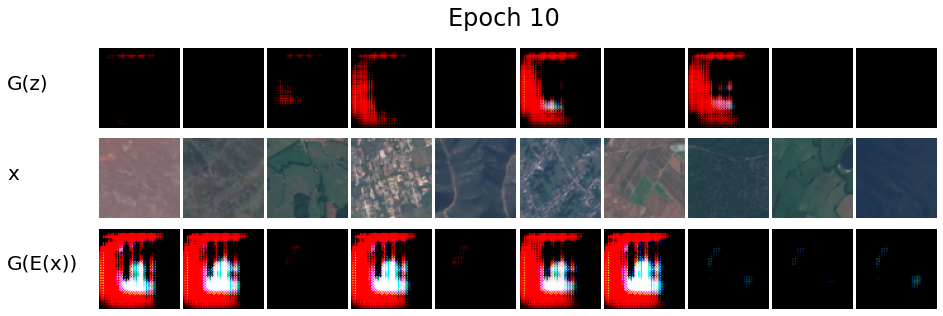

Epoch [20/100], Avg_Loss_D: 0.2157, Avg_Loss_EG: 16.4821


torch.Size([3, 64, 64])


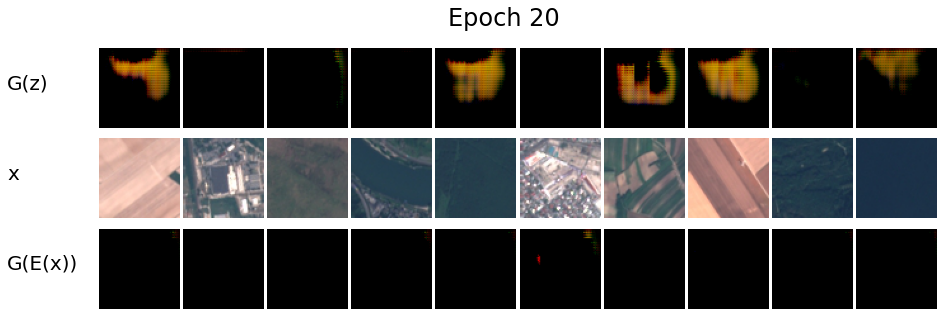

Epoch [30/100], Avg_Loss_D: 0.0562, Avg_Loss_EG: 14.1375


torch.Size([3, 64, 64])


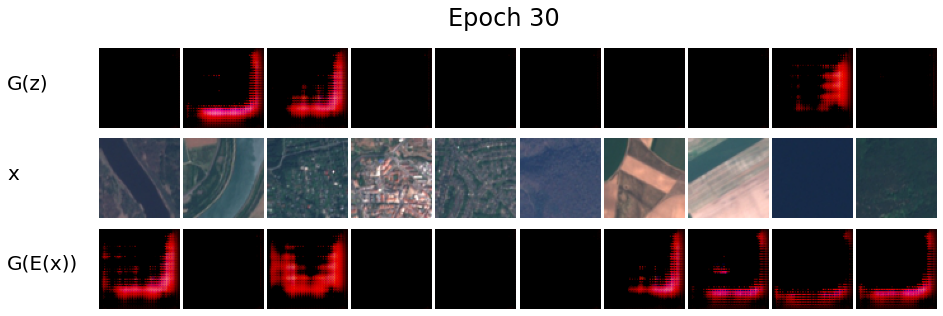

Epoch [40/100], Avg_Loss_D: 0.0446, Avg_Loss_EG: 20.9576


torch.Size([3, 64, 64])


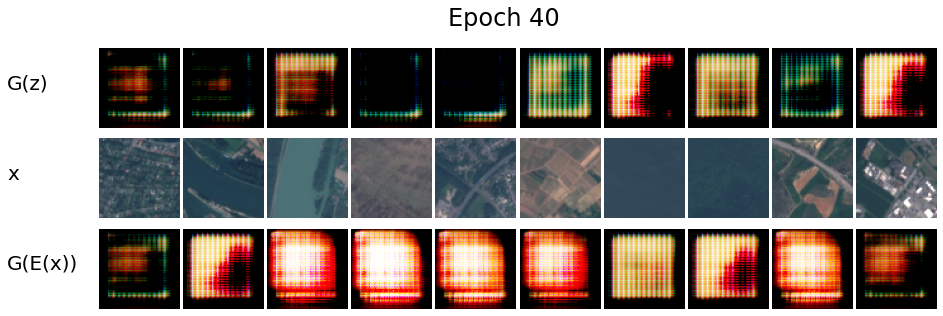

Epoch [50/100], Avg_Loss_D: 0.0259, Avg_Loss_EG: 20.3197


torch.Size([3, 64, 64])


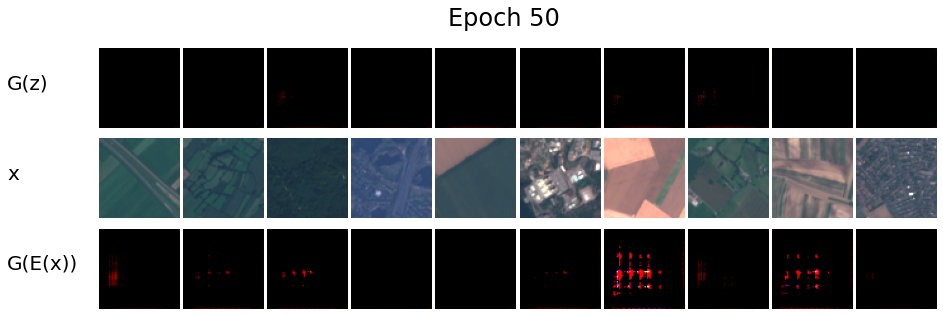

Epoch [60/100], Avg_Loss_D: 0.0406, Avg_Loss_EG: 18.8178


torch.Size([3, 64, 64])


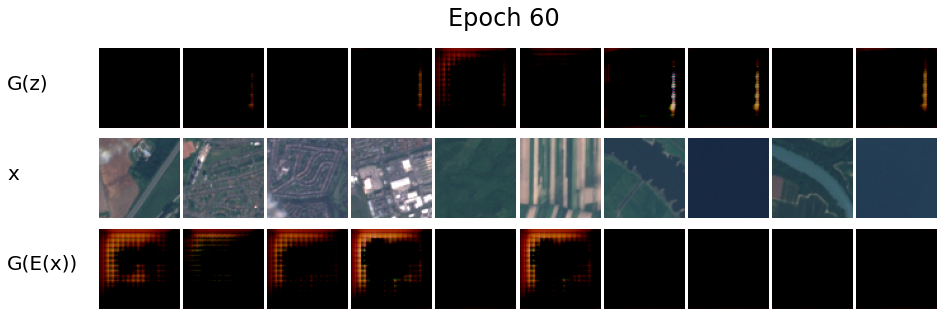

Epoch [70/100], Avg_Loss_D: 0.0371, Avg_Loss_EG: 17.8703


torch.Size([3, 64, 64])


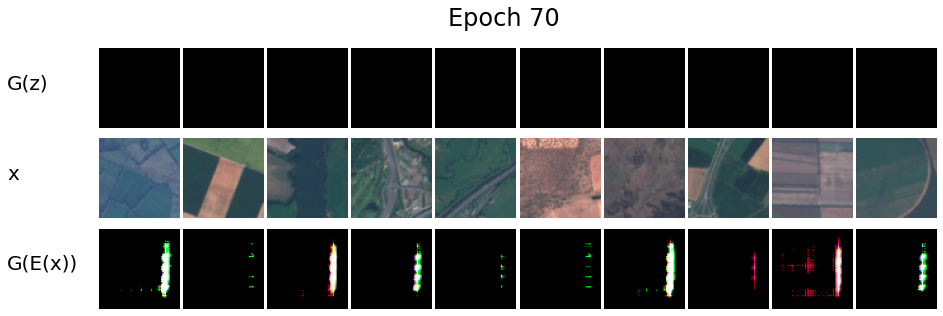

Epoch [80/100], Avg_Loss_D: 0.0033, Avg_Loss_EG: 31.7591


torch.Size([3, 64, 64])


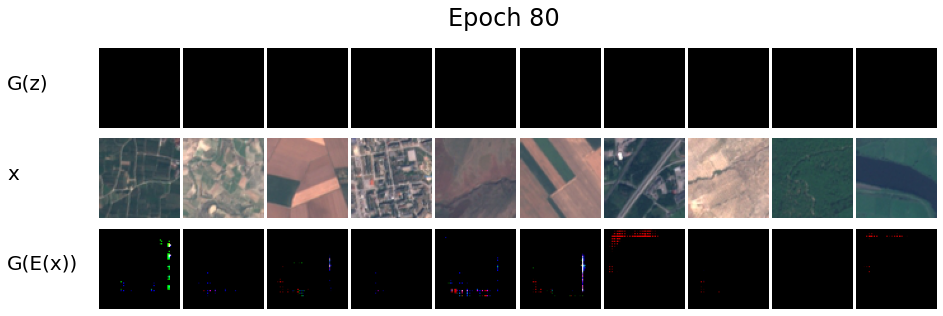

Epoch [90/100], Avg_Loss_D: 0.0016, Avg_Loss_EG: 38.2778


torch.Size([3, 64, 64])


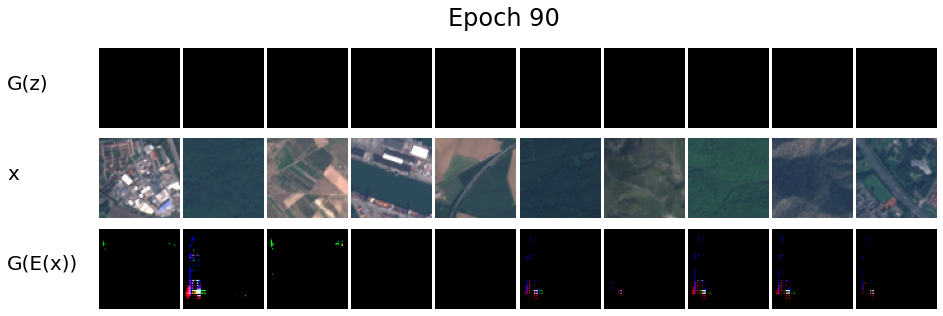

Epoch [100/100], Avg_Loss_D: 0.0011, Avg_Loss_EG: 58.5278


torch.Size([3, 64, 64])


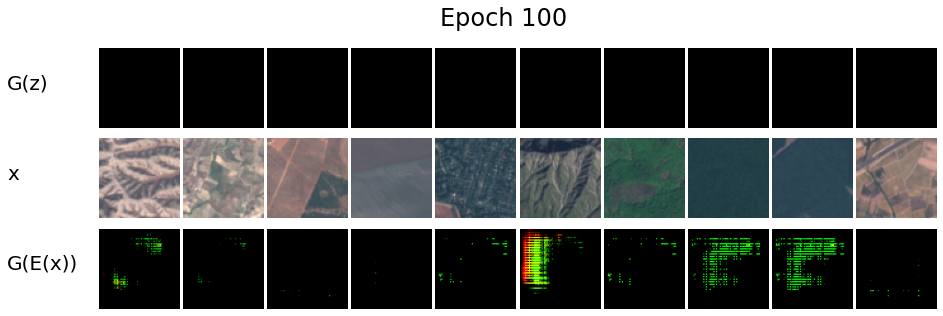

In [ ]:
torch.autograd.set_detect_anomaly(False)

#criterion_D = nn.BCELoss()
#criterion_EG = nn.BCELoss()

for epoch in range(n_epochs):
    D_loss_acc = 0.
    EG_loss_acc = 0.
    D.train()
    E.train()
    G.train()
        
#     scheduler_D.step()
#     scheduler_EG.step()
    
    for i, (images, labels) in enumerate(tv_train_dataloader):

        real_label = Variable(torch.ones(batch_size).unsqueeze(1)).to(device)
        fake_label = Variable(torch.zeros(batch_size).unsqueeze(1)).to(device)

        X = Variable(images).to(device)
        
        #initialize z from 100-dim U[-1,1]
        z = Variable(torch.randn(batch_size, nz))
        z = z.to(device)
        
        z_hat = E(X)
        X_hat = G(z)
        
        #compute D(X, E(X)) and D(G(z), z)
        D_enc = D(X, z_hat)
        z = z.unsqueeze(2).unsqueeze(3)
        D_gen = D(X_hat, z)
        
        #compute losses, binary cross entropy
        #D_loss = -torch.mean(log(D_enc) + log(1 - D_gen))
        #EG_loss = -torch.mean(log(D_gen) + log(1 - D_enc))

        #D_loss = criterion_D(D_enc, real_label) + criterion_D(D_gen, fake_label)
        #EG_loss = criterion_EG(D_gen, real_label) + criterion_EG(D_enc, fake_label)

        
        EG_loss = adversarial_loss(D_gen, real_label) + adversarial_loss(D_enc, fake_label)

        #Encoder & Generator training
        optimizer_EG.zero_grad()
        EG_loss.backward()
        optimizer_EG.step()
        
        D_enc = D(X.detach(), z_hat.detach())
        z = z.detach().unsqueeze(2).unsqueeze(3)
        D_gen = D(X_hat.detach(), z.detach())

        D_loss = adversarial_loss(D_enc, real_label) + adversarial_loss(D_gen, fake_label)

        #Discriminator training
        optimizer_D.zero_grad()
        D_loss.backward(retain_graph=True)
        optimizer_D.step()


        # append losses
        D_loss_acc += D_loss.item()
        EG_loss_acc += EG_loss.item()

    if (epoch+1) % 10 == 0:  
        print('Epoch [{}/{}], Avg_Loss_D: {:.4f}, Avg_Loss_EG: {:.4f}'.format(epoch + 1, n_epochs, D_loss_acc / i, EG_loss_acc / i))
        torch.save(G.state_dict(), '%s/G_epoch_%d.pth' % (models_directory, epoch))
        torch.save(E.state_dict(), '%s/E_epoch_%d.pth' % (models_directory, epoch))
        torch.save(D.state_dict(), '%s/D_epoch_%d.pth' % (models_directory, epoch))
        
        n_show = 10
        D.eval()
        E.eval()
        G.eval()

        with torch.no_grad():
            real = images[:n_show]
            real = real.to(device)
            z = torch.randn(n_show, nz)
            z = z.to(device)
            gener = G(z).cpu()
            z_hat = E(real)
            z_hat = z_hat.squeeze(2).squeeze(2)
            recon = G(z_hat).cpu()
            real = real.cpu()

            fig, ax = plt.subplots(3, n_show, figsize=(15,5))
            fig.subplots_adjust(wspace=0.05, hspace=0)
            plt.rcParams.update({'font.size': 20})
            fig.suptitle('Epoch {}'.format(epoch+1))
            fig.text(0.04, 0.75, 'G(z)', ha='left')
            fig.text(0.04, 0.5, 'x', ha='left')
            fig.text(0.04, 0.25, 'G(E(x))', ha='left')

            print(gener[1].shape)

            for i in range(n_show):
                ax[0, i].imshow(gener[i].permute(1, 2, 0), cmap='gray')
                ax[0, i].axis('off')
                ax[1, i].imshow(real[i].permute(1, 2, 0), cmap='gray')
                ax[1, i].axis('off')
                ax[2, i].imshow(recon[i].permute(1, 2, 0), cmap='gray')
                ax[2, i].axis('off')
            plt.show()